<a href="https://colab.research.google.com/github/qianyu-berkeley/NLP_study/blob/main/nlp_tasks/Summarization_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summarization (PyTorch)

## Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

* Most of the summerization dataset is in English
* We will use a bilingual dataset to demo

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already 

You will need to setup git, adapt your email and name in the following cell.

In [2]:
!git config --global user.email "qianyu.bayarea@gmail.com"
!git config --global user.name "qianyu-berkeley"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [5]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)


'>> Title: Worked in front position, not rear'
'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.'

'>> Title: meh'
'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue'

'>> Title: Can't beat these for the money'
'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. 

### To reduce training time, use a single domain of data

In [6]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: product_category, dtype: int64

In [7]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

In [8]:
# Switch back from pandas to arrow
english_dataset.reset_format()

In [9]:
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]


'>> Title: I'm dissapointed.'
'>> Review: I guess I had higher expectations for this book from the reviews. I really thought I'd at least like it. The plot idea was great. I loved Ash but, it just didnt go anywhere. Most of the book was about their radio show and talking to callers. I wanted the author to dig deeper so we could really get to know the characters. All we know about Grace is that she is attractive looking, Latino and is kind of a brat. I'm dissapointed.'

'>> Title: Good art, good price, poor design'
'>> Review: I had gotten the DC Vintage calendar the past two years, but it was on backorder forever this year and I saw they had shrunk the dimensions for no good reason. This one has good art choices but the design has the fold going through the picture, so it's less aesthetically pleasing, especially if you want to keep a picture to hang. For the price, a good calendar'

'>> Title: Helpful'
'>> Review: Nearly all the tips useful and. I consider myself an intermediate to a

To create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:

In [10]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(books_dataset)


'>> Title: Easy to follow!!!!'
'>> Review: I loved The dash diet weight loss Solution. Never hungry. I would recommend this diet. Also the menus are well rounded. Try it. Has lots of the information need thanks.'

'>> Title: PARCIALMENTE DAÑADO'
'>> Review: Me llegó el día que tocaba, junto a otros libros que pedí, pero la caja llegó en mal estado lo cual dañó las esquinas de los libros porque venían sin protección (forro).'

'>> Title: no lo he podido descargar'
'>> Review: igual que el anterior'


In [11]:
books_dataset.set_format("pandas")
books_df = books_dataset["train"][:]
books_df["number_of_words"] = books_df['review_title'].apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

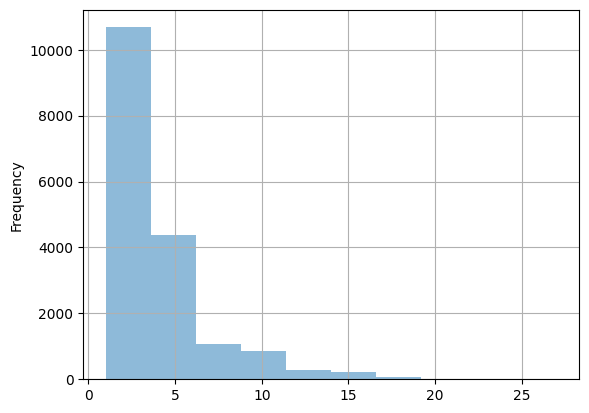

In [12]:
books_df["number_of_words"].plot(kind='hist', grid=True, alpha=0.5)

Review titles (which is the label of the dataset i.e. summerization) are heavily skew towards short titles, we filter out those short titles to make the model summarization more interesting meaning we use longer summarization label

In [13]:
books_dataset.reset_format()
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)
books_dataset

Filter:   0%|          | 0/17612 [00:00<?, ? examples/s]

Filter:   0%|          | 0/424 [00:00<?, ? examples/s]

Filter:   0%|          | 0/442 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 9672
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 238
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 245
    })
})

## Model Text Summarization

* We use mode `mT5`
* `mT5` is based on `T5` which was pretrained in a text-to-text framework.
* In T5, every NLP task is formulated in terms of a prompt prefix like summarize, `mT5` does not use prefixes but has the advantage of multilingual
* Start with small checkpoint (In the early stages of your NLP projects, a good practice is to train a class of “small” models on a small sample of data. This allows you to debug and iterate faster toward an end-to-end workflow. )

In [14]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Data Preprocessing

* The tokenizer use `_` and `</s>` indicating it is using `SentencePiece`


In [15]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 62893, 295, 12507, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hung', 'er', '▁Games', '!', '</s>']

* Need to use different max length for input and target because targets have shorter text

In [17]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [18]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/9672 [00:00<?, ? examples/s]

Map:   0%|          | 0/238 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

### Metric: ROUGE Score

* `ROUGE` stands for Recall-Oriented Understudy for Gisting Evaluation
* compare a generated summary against a set of reference summaries that are typically created by humans
* based on computing the precision and recall scores for the overlap.
    * `recall` measures how much of the reference summary is captured by the generated one
$$ Recall= \frac{Total\ number\ of\ words\ in\ reference\ summary}{ Number\ of\ overlapping\ words} $$​
    * `precision` measures how much of the generated summary was relevant:
$$ Precision = \frac{Total\ number\ of\ words\ in\ generated\ summary}{ Number\ of\ overlapping\ words} $$​



In [19]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [20]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=81a97ad0bc3e9c43697bf282456933924dacc93db532b4c7625dc89fd5dfe17a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [21]:
import evaluate

rouge_score = evaluate.load("rouge")

In [22]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [23]:
scores["rouge1"]

0.923076923076923

### Create Baseline Metrics

A common baseline for text summarization is to simply take the first three sentences of an article, often called the `lead-3 baseline`.

In [24]:
!pip install nltk

In [25]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

I grew up reading Koontz, and years ago, I stopped,convinced i had "outgrown" him.
Still,when a friend was looking for something suspenseful too read, I suggested Koontz.
She found Strangers.


In [27]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [28]:
import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 16.85, 'rouge2': 8.87, 'rougeL': 15.53, 'rougeLsum': 15.95}

## Fine-tuning with Trainer API

In [29]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [30]:
from huggingface_hub import notebook_login

notebook_login()

`Seq2SeqTrainingArgument` and `Seq2SeqTrainer` class generate summaries to for computing ROUGE automatically

* `predict_with_generate = True` indicate we should generate summaries during evaluation so taht we can compute ROUGE score for each epoch

In [31]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [32]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [33]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [34]:
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

In [35]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[   653,   1957,   1314,    261,   2757,   1280,    435,    259,  29166,
            263,    269,    774,   5547,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              

In [36]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,7.340100,3.346536,14.190100,6.266000,13.859400,13.775200
2,3.919500,3.185934,15.944000,8.254100,15.315600,15.361500
3,3.597500,3.094468,17.512200,9.131800,16.838800,17.011400
4,3.424100,3.091303,16.401100,7.794900,15.797600,15.790200
5,3.325200,3.058782,16.598600,8.178300,16.129400,16.099700
6,3.244200,3.044448,17.108500,8.450000,16.691200,16.655000
7,3.214900,3.035524,17.308000,8.819000,16.916600,16.930600
8,3.184000,3.034919,17.022900,8.450000,16.630700,16.657200


TrainOutput(global_step=9672, training_loss=3.9061914385597603, metrics={'train_runtime': 3434.6446, 'train_samples_per_second': 22.528, 'train_steps_per_second': 2.816, 'total_flos': 1.1906575558656e+16, 'train_loss': 3.9061914385597603, 'epoch': 8.0})

In [38]:
trainer.evaluate()

{'eval_loss': 3.034918785095215,
 'eval_rouge1': 17.0229,
 'eval_rouge2': 8.45,
 'eval_rougeL': 16.6307,
 'eval_rougeLsum': 16.6572,
 'eval_runtime': 10.5481,
 'eval_samples_per_second': 22.563,
 'eval_steps_per_second': 2.844,
 'epoch': 8.0}

## Fine-tuning mT5 with Accelerate

* need to explicitly generate our summaries during training and define how we compute the ROUGE scores (trainer API uses `Seq2SeqTrainer` to generate)

Steps:

* Create a dataloader for each splits
* instantiate the data collator for dataLoader
* define optimizer
* define a learning rate schedule
* define post-processing function for evaluation

In [35]:
tokenized_datasets.set_format("torch")

In [36]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [37]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

In [38]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [39]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [40]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [41]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [42]:
from huggingface_hub import get_full_repo_name

model_name = "test-bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'qianyu88/test-bert-finetuned-squad-accelerate'

In [43]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

Cloning https://huggingface.co/qianyu88/test-bert-finetuned-squad-accelerate into local empty directory.


In [44]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/12090 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 0: {'rouge1': 1.4374, 'rouge2': 0.0764, 'rougeL': 1.3029, 'rougeLsum': 1.271}


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 1: {'rouge1': 2.0813, 'rouge2': 0.1528, 'rougeL': 1.9851, 'rougeLsum': 1.9617}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 2: {'rouge1': 3.342, 'rouge2': 0.3975, 'rougeL': 3.1856, 'rougeLsum': 3.1396}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 3: {'rouge1': 7.7274, 'rouge2': 1.1212, 'rougeL': 7.4848, 'rougeLsum': 7.5245}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 4: {'rouge1': 9.5353, 'rouge2': 1.8276, 'rougeL': 9.2343, 'rougeLsum': 9.2435}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 5: {'rouge1': 9.3208, 'rouge2': 2.136, 'rougeL': 8.9918, 'rougeLsum': 9.0038}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 6: {'rouge1': 10.0759, 'rouge2': 2.8043, 'rougeL': 9.8888, 'rougeLsum': 9.8972}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 7: {'rouge1': 10.1788, 'rouge2': 2.816, 'rougeL': 9.818, 'rougeLsum': 9.918}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 8: {'rouge1': 10.1752, 'rouge2': 3.1187, 'rougeL': 9.9754, 'rougeLsum': 10.048}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 9: {'rouge1': 10.3283, 'rouge2': 3.1633, 'rougeL': 10.1402, 'rougeLsum': 10.2581}


In [45]:
from transformers import pipeline

hub_model_id = "qianyu88/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

In [46]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [47]:
print_summary(100)

Your max_length is set to 20, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


'>>> Review: Muy apropiado para mis hijas'

'>>> Title: Libros para el verano'

'>>> Summary: Muy buen libro'


In [48]:
print_summary(0)

'>>> Review: Es una trilogia que se hace muy facil de leer. Me ha gustado, no me esperaba el final para nada'

'>>> Title: Buena literatura para adolescentes'

'>>> Summary: No me esperaba el final'
